In [1]:
# import
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random
from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
# set defaults
plt.rcParams['figure.dpi'] = 80


/Users/danielgchen/anaconda3/envs/base_py37/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Data Processing

## Load Data

In [2]:
# read data
df = pd.read_csv('../data/kddcup.data_0_1_percent.csv', index_col=0)
df.head()  # small view


,0,1,2,3,4,5,6,7,8,9,...,32,33,34,35,36,37,38,39,40,41
22650,1,tcp,smtp,SF,1022,389,0,0,0,0,...,175,0.64,0.02,0.01,0.02,0.0,0.0,0.0,0.0,normal.
5765,0,tcp,http,SF,376,285,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,normal.
241826,0,icmp,ecr_i,SF,1032,0,0,0,0,0,...,255,1.00,0.00,1.00,0.00,0.0,0.0,0.0,0.0,smurf.
292391,0,icmp,ecr_i,SF,1032,0,0,0,0,0,...,255,1.00,0.00,1.00,0.00,0.0,0.0,0.0,0.0,smurf.
392127,0,tcp,private,S0,0,0,0,0,0,0,...,1,0.00,0.06,0.00,0.00,1.0,1.0,0.0,0.0,neptune.


## Subset Data

In [3]:
# filter labels
labels = df['41'].value_counts()  # n-obs / label
mask = labels > df.shape[0] * 0.05  # label must encompass > 5% of the data
labels = labels.index[mask]  # get passing labels
print(f'Passing labels = {labels.tolist()}')
df = df[df['41'].isin(labels)]


Passing labels = ['smurf.', 'neptune.', 'normal.']


# Run Model

We'll run this model using only what is "normal" as this allows for the density to be hyper-tuned

## Prepare Data

In [4]:
# set random seeds
random_state = 0
random.seed(random_state)
np.random.seed(random_state)
# split data
# - if it's an intrusion
df_normal = df[df['41']=='normal.']
df_intrusion = df[df['41']!='normal.']
# - normal ml splitting
X, y = df_normal.iloc[:, :-1], df_normal.iloc[:, -1]  # last column is label
for col in X.columns:
    le = LabelEncoder()  # instantiate one-hot-encoder
    le.fit(X[col])  # fit the classes
    X[col] = le.transform(X[col])  # transform data
params = train_test_split(X, y, test_size=1/4, random_state=random_state, shuffle=True, stratify=y)
X_train, X_test, y_train, y_test = params


## Instantiate Model

Local density factor utilizes a neighborhood graph to determine the density of an observation, the more neighbors the point has, the more dense it is in the high-dimensional space and thus the more "inliner" it is likely to be.

In [5]:
# fit model - utilizes "density" to group samples together
model = LocalOutlierFactor(n_neighbors=20, novelty=True)
model.fit(X_train)


LocalOutlierFactor(algorithm='auto', contamination='auto', leaf_size=30,
                   metric='minkowski', metric_params=None, n_jobs=None,
                   n_neighbors=20, novelty=True, p=2)

### Evaluate Model

When evaluating LOF results, the decision function returns the inliner score (density), larger score = more dense and  more likely it is an inliner observation.

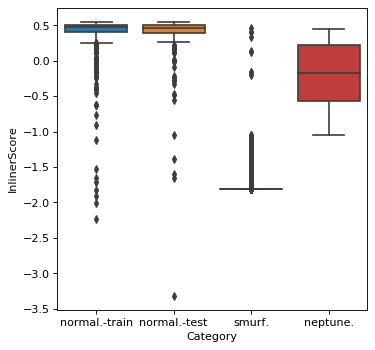

In [6]:
# plot values
# - construct dataframe
plot_df1A = pd.DataFrame(model.decision_function(X_train), columns=['InlinerScore'])
plot_df1A['Category'] = (y_train + '-train').values
plot_df1B = pd.DataFrame(model.decision_function(X_test), columns=['InlinerScore'])
plot_df1B['Category'] = (y_test + '-test').values
X_test_intrusion = df_intrusion.iloc[:, :-1]
for col in X_test_intrusion.columns:
    le = LabelEncoder()  # instantiate one-hot-encoder
    le.fit(X_test_intrusion[col])  # fit the classes
    X_test_intrusion[col] = le.transform(X_test_intrusion[col])  # transform data
plot_df2 = pd.DataFrame(model.decision_function(X_test_intrusion), columns=['InlinerScore'])
plot_df2['Category'] = df_intrusion.iloc[:, -1].values
plot_df = pd.concat([plot_df1A, plot_df1B, plot_df2])
# - plot boxplot
fig,ax = plt.subplots(figsize=[5,5])
sns.boxplot(x='Category', y='InlinerScore', data=plot_df, ax=ax)


There are more observations here from the "normal" categories that are mis-assigned as anomalies, this may be due to the sole reliance of kNN-based detection on density-related factors rather than the rule-based density-influenced algorithm that isolation forest utilizes.

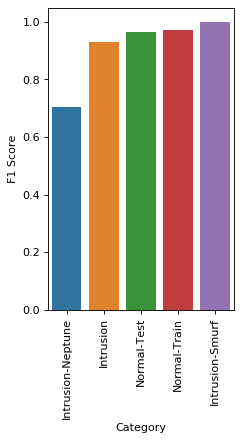

In [7]:
from sklearn.metrics import f1_score
# compute f1 scores
f1_normal_train = f1_score([1]*X_train.shape[0], model.predict(X_train), pos_label=1)
f1_normal_test = f1_score([1]*X_test.shape[0], model.predict(X_test), pos_label=1)
f1_intrusion_smurf = f1_score([-1]*sum(df['41']=='smurf.'),
                              model.predict(X_test_intrusion[df_intrusion.iloc[:, -1]=='smurf.']), pos_label=-1)
f1_intrusion_neptune = f1_score([-1]*sum(df['41']=='neptune.'),
                                model.predict(X_test_intrusion[df_intrusion.iloc[:, -1]=='neptune.']), pos_label=-1)
f1_intrusion = f1_score([-1]*X_test_intrusion.shape[0], model.predict(X_test_intrusion), pos_label=-1)

# construct dataframe
f1_scores = [f1_normal_train, f1_normal_test, f1_intrusion_smurf, f1_intrusion_neptune, f1_intrusion]
categories = ['Normal-Train', 'Normal-Test', 'Intrusion-Smurf', 'Intrusion-Neptune', 'Intrusion']
plot_df = pd.DataFrame([f1_scores, categories], index=['F1 Score', 'Category']).T
plot_df = plot_df.sort_values('F1 Score')

# plot boxplot
fig,ax = plt.subplots(figsize=[3,5])
sns.barplot(x='Category', y='F1 Score', data=plot_df, ax=ax)
ax.tick_params(axis='x', labelrotation=90)


Using the F1-score (weighted measurment of precision and recall) we find that the model excels in normal detection but fails in terms of "neptune" intrusion detection, which agrees with the previous boxplot.